### Jump right in with the MNIST database

MNIST dataset is a release from American Data/Computer Scientists containing labeled images of hand-written numerals. We use this dataset to train our system to recognize a handwritten character. Later, we test our system against another smaller but unlabeled dataset (from the same team) to verify the accuracy of our system.

#### Step 1: Download the dataset

Read more about the dataset at [Yann LeCun's webpage](http://yann.lecun.com/exdb/mnist/)

In [40]:
%matplotlib inline

import sys
import gzip
import struct
import numpy as np
import tensorflow as tf
import urllib.request as req
import matplotlib.pyplot as plt

from io import BytesIO

In [19]:
urls = {
    'training_set': 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
    'training_set_labels': 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
}

def download(name, url):
    res = req.urlopen(url)
    byts = res.read()
    comp = BytesIO(byts)
    # The downloads offered are compressed as gzip file
    # need to decompress them
    decomp = gzip.GzipFile(fileobj=comp)
    with open(name, 'wb') as fp:
        fp.write(decomp.read())
    

for k, v in urls.items():
    download(k, v)

KeyboardInterrupt: 

The two files are now downloaded with names `training_set` and `training_set_labels` in the local directory.

#### Step 2: Parse the files

Even though we are working on an image dataset, there actually are no images that we can double click to view in the dataset we just downloaded. Instead the images are described as serialised bytes in the binary file we downloaded with name `training_set`.

We can safely ignore the first four bytes (one 32-bit integer) in the file. The next 4 bytes represent the number of images described in the file and can be decoded as a 32-bit integer. Similarly, the next 4 bytes represent the width in pixels of each image and the next four represent the height again in pixels.

In [23]:
ign_num = None
pix_width = None
pix_height = None
num_images = None

with open('./training_set', 'rb') as trainfp:
    # We ignore first 4 bytes
    ign_num, = struct.unpack('>i', trainfp.read(4))
    
    # Next 4 bytes represent the number of images in the dataset
    num_images, = struct.unpack('>i', trainfp.read(4))
    
    # Next 4 bytes represent width (in pixels) of each image
    pix_width, = struct.unpack('>i', trainfp.read(4))
    
    # Next 4 bytes represent height (in pixels) of each image
    pix_height, = struct.unpack('>i', trainfp.read(4))

# We ensure are read were successful for further progress
assert(type(ign_num) is int)
assert(type(num_images) is int)
assert(type(pix_width) is int)
assert(type(pix_height) is int)

print('Number of images:', num_images)
print('Dimension of each image (wxh):', '{0}x{1}'.format(pix_width, pix_height))

Number of images: 60000
Dimension of each image (wxh): 28x28


#### Step 3: Reading the images from the dataset

After the first sixteen bytes, each byte now represents a pixel and a block of 28 bytes represents a row of one image. If the byte is set to 0 (0=0x00) implies the pixel is inactive or empty and if the byte is set to 255 (255=0xff) implies the pixel is active.

A group of 28 consequtive such bytes make for 1 row of the image. The next 28 bytes represent the second row. Since the dimension of each image is `28x28` we need to read 28 total such rows to get the full image.

Lets parse one such image from the file and view it.

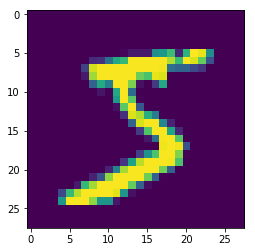

In [35]:
def next_image(fp):
    img_size = pix_width * pix_height
    img_bytes = fp.read(img_size)
    fields = '>' + ('B' * img_size)
    arr = np.array(struct.unpack(fields, img_bytes))
    return arr.reshape(pix_width, pix_height)

trainfp = open('./training_set', 'rb')
trainfp.seek(16)
plt.imshow(next_image(trainfp))

This one looks like `5`. Lets try another one.

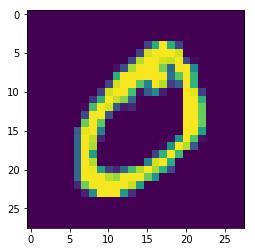

In [36]:
plt.imshow(next_image(trainfp))

That seems to be a zero. Lets see next one.

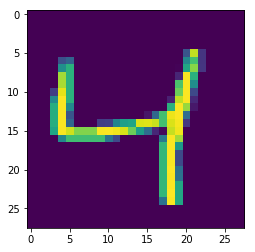

In [38]:
plt.imshow(next_image(trainfp))

That is a `4`. We need not do the same for rest 59996 images, `training_set_labels` file contains a mapping for number represented by each image and we can rely on it to label our dataset.
Let us build our Tensor:

In [50]:
flatarr = [ struct.unpack(fields, trainfp.read(img_size)) for x in range(59996) ]

In [71]:
flatarr = [ tf.convert_to_tensor(x) for x in flatarr ]

[<tf.Tensor 'Const_16:0' shape=(784,) dtype=int64>,
 <tf.Tensor 'Const_17:0' shape=(784,) dtype=int64>,
 <tf.Tensor 'Const_18:0' shape=(784,) dtype=int64>,
 <tf.Tensor 'Const_19:0' shape=(784,) dtype=int64>,
 <tf.Tensor 'Const_20:0' shape=(784,) dtype=int64>,
 <tf.Tensor 'Const_21:0' shape=(784,) dtype=int64>,
 <tf.Tensor 'Const_22:0' shape=(784,) dtype=int64>,
 <tf.Tensor 'Const_23:0' shape=(784,) dtype=int64>,
 <tf.Tensor 'Const_24:0' shape=(784,) dtype=int64>,
 <tf.Tensor 'Const_25:0' shape=(784,) dtype=int64>,
 <tf.Tensor 'Const_26:0' shape=(784,) dtype=int64>,
 <tf.Tensor 'Const_27:0' shape=(784,) dtype=int64>,
 <tf.Tensor 'Const_28:0' shape=(784,) dtype=int64>,
 <tf.Tensor 'Const_29:0' shape=(784,) dtype=int64>,
 <tf.Tensor 'Const_30:0' shape=(784,) dtype=int64>,
 <tf.Tensor 'Const_31:0' shape=(784,) dtype=int64>,
 <tf.Tensor 'Const_32:0' shape=(784,) dtype=int64>,
 <tf.Tensor 'Const_33:0' shape=(784,) dtype=int64>,
 <tf.Tensor 'Const_34:0' shape=(784,) dtype=int64>,
 <tf.Tensor 

In [74]:
x = tf.placeholder(tf.float32, [None, img_size])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.nn.softmax(tf.matmul(x, W) + b)
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
sess.run(train_step, feed_dict={x: flatarr[0].eval().reshape(1, img_size), y_: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]})

ValueError: Cannot feed value of shape (10,) for Tensor 'Placeholder_47:0', which has shape '(?, 10)'